# Experiment: Cohesion
To goal of cohesion is to maintain a cohesive collective whose network structure is neither too dense nor too sparse.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib

matplotlib.rcParams['figure.figsize'] = [12, 8]

import math
import numpy as np

from interaction import Interaction
from environment import Environment
from fish import Fish
from channel import Channel
from observer import Observer

from utils import generate_distortion, generate_fish, run_simulation

### Dispersion
All robots start in the same place and have too many neighbors. They disperse to decrease their number of neighbors.

In [3]:
run_time = 30 # in seconds
num_fish = 20
arena_size = 30
arena_center = arena_size / 2.0
initial_spread = 1
fish_pos = initial_spread * np.random.rand(num_fish, 2) + arena_center - initial_spread / 2.0
clock_freqs = 1
verbose = False

distortion = generate_distortion(type='none', n=arena_size)
environment = Environment(
    node_pos=fish_pos,
    distortion=distortion,
    prob_type='binary', 
    noise_magnitude=0,
    conn_thres=6,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)

fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    interaction=interaction, 
    lim_neighbors=[2,3],
    neighbor_weights=1.0,
    fish_max_speeds=1,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish)

observer = Observer(fish=fish, environment=environment, channel=channel)
run_simulation(fish=fish, observer=observer, run_time=run_time, dark=True, white_axis=False, no_legend=True)

Please wait patiently 30 seconds. Thanks.


### Aggregation in a counterclockwise curl
They robots start spread out and have too few neighbors. They aggregate to increase their number of neighbors. While doing so, they are affacted by a distortion of the type of a counterclockwise curl.

In [4]:
run_time = 20 # in seconds
num_fish = 50
arena_size = 30
arena_center = arena_size / 2.0
initial_spread = 25
fish_pos = initial_spread * np.random.rand(num_fish, 2) + arena_center - initial_spread / 2.0
clock_freqs = 1
verbose = False

distortion = generate_distortion(type='curl', n=arena_size)
environment = Environment(
    node_pos=fish_pos,
    distortion=distortion,
    prob_type='binary',
    noise_magnitude=0,
    conn_thres=10,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)

fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    interaction=interaction, 
    lim_neighbors=[math.inf,math.inf],
    neighbor_weights=1.0,
    fish_max_speeds=1,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish)

observer = Observer(fish=fish, environment=environment, channel=channel)
run_simulation(fish=fish, observer=observer, run_time=run_time, dark=True, white_axis=False, no_legend=True)

Please wait patiently 20 seconds. Thanks.


### Aggregation and migration
The robots start dispersed and gather first to then migrate from left to right. This is similar to salmons who come from different places in the ocean and then swim up their rivers of origin for reproduction.

Please wait patiently 20 seconds. Thanks.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

It's time to say bye bye!


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

It's time to say bye bye!


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


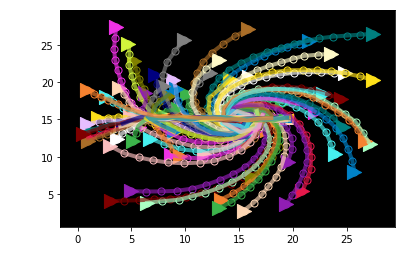

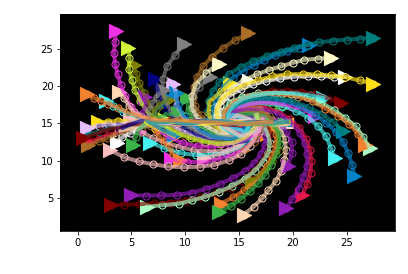

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

It's time to say bye bye!


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

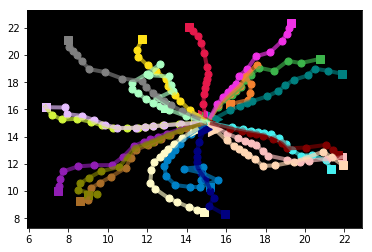

In [5]:
from events import Move

run_time = 20 # in seconds
num_fish = 25
arena_size = 30
arena_center = arena_size / 2.0
initial_spread = 10
fish_pos = np.zeros((num_fish,2))
fish_pos[:,0] = np.random.rand(num_fish) * initial_spread
fish_pos[:,1] = np.random.rand(num_fish) * initial_spread + arena_center - initial_spread/2
clock_freqs = 1
verbose = False

distortion = generate_distortion(type='none', n=arena_size)
environment = Environment(
    node_pos=fish_pos,
    distortion=distortion,
    prob_type='binary',
    noise_magnitude=0.2,
    conn_thres=10,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)

fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    interaction=interaction, 
    lim_neighbors=[math.inf,math.inf],
    neighbor_weights=1.0,
    fish_max_speeds=1,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish)

observer = Observer(fish=fish, environment=environment, channel=channel)

migrate = Move(1,0)
observer.instruct(event=migrate, rel_clock=0, fish_all=True)

run_simulation(fish=fish, observer=observer, run_time=run_time, dark=True, white_axis=False, no_legend=True, no_star=True)